# Prepare the Environment

In [1]:
!pip install gdown
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 6.7 MB/s 
     |████████████████████████████████| 1.6 MB 12.9 MB/s 


# Download the Dataset

In [2]:
!gdown 14MbR3H3uK80UXzlTADhF9KGV5R-kYXGH # train
!gdown 1S0qoDdzz6t9rVUItEKOQPQm5OHSoCDCf # train_accessories_processed

Downloading...
From: https://drive.google.com/uc?id=14MbR3H3uK80UXzlTADhF9KGV5R-kYXGH
To: /content/train.zip
100% 3.99M/3.99M [00:00<00:00, 172MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S0qoDdzz6t9rVUItEKOQPQm5OHSoCDCf
To: /content/train_accessories_processed.zip
100% 1.04M/1.04M [00:00<00:00, 128MB/s]


Unzip and save the dataset in *tmp* folder

In [3]:
import os
import zipfile


zip_ref = zipfile.ZipFile("./train.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

zip_ref = zipfile.ZipFile("./train_accessories_processed.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

os.remove("train.zip")
os.remove("train_accessories_processed.zip")

# Import Libraries

In [4]:
SEED = 42

import os
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [5]:
import re

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve

import tensorflow.keras as keras
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

import keras_tuner as kt

%matplotlib inline

In [6]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# colors

# Computation of the Eigenfaces

Set the size for training images

In [7]:
train_data_dir = "tmp/train"
DEFAULT_SIZE = [448, 448]

Convert images to list of numpy arrays and reshape these arrays as 1D column vectors.

In [8]:
def image_to_array(data_dir, default_size=DEFAULT_SIZE):
  images = []
  image_names = []
  for person in os.listdir(data_dir):
    person_dir = os.path.join(data_dir, person)
    for img_name in os.listdir(person_dir):
      image_names.append(img_name)
      image = Image.open(os.path.join(person_dir, img_name))
      image = ImageOps.exif_transpose(image)
      image = image.convert('L')  # greyscale
      image = image.resize(default_size)

      images.append(np.asarray(image, dtype=np.uint8).reshape(-1, 1))
      
  return [images, image_names]

In [9]:
[faces, names] = image_to_array(train_data_dir)

 Append face vectors to matrix

In [10]:
# assemble image to data matrix, each column is 1 image
face_matrix = np.empty((faces[0].size, 0), dtype=faces[0].dtype)
for face in faces:
  face_matrix = np.hstack((face_matrix, face)) # R*C x 1

Get the mean face

Text(0.5, 1.0, 'Mean Face')

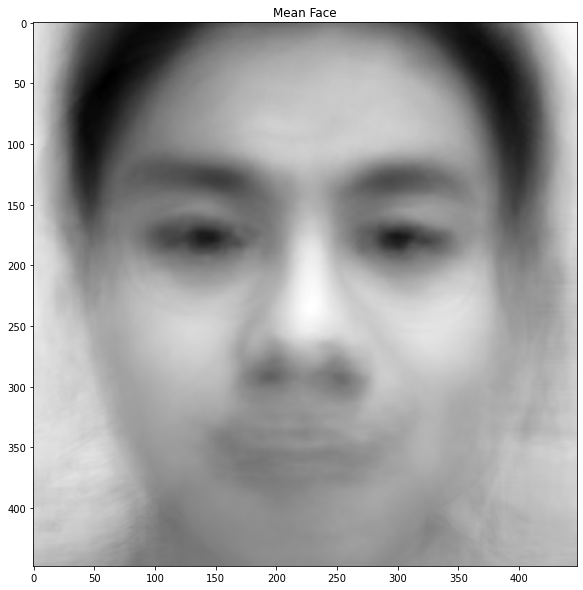

In [11]:
average_weight_matrix = face_matrix.mean(axis=1).reshape(DEFAULT_SIZE)
plt.imshow(average_weight_matrix, cmap=plt.cm.gray)
plt.title("Mean Face")

In [12]:
def num_of_principal_components(eigenvalues, variance=.95):
  for numofcomp, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
    if eigen_value_cumsum > variance:
      return numofcomp

In [13]:
def pca(X):
  [rows, images] = X.shape
  num_components = rows
  mu = X.mean(axis=1, keepdims=True)
  X = X - mu

  # use smaller dimension C is covarience matrix
  if rows < images:
    C = np.matmul(X, X.T)
    [eigenvalues, eigenvectors] = np.linalg.eigh(C)
  else:
    C = np.matmul(X.T, X)
    [eigenvalues, eigenvectors] = np.linalg.eigh(C)
    eigenvectors = np.matmul(X, eigenvectors)
      
  # sort eigenvectors descending by their eigenvalue
  dxvalues = np.argsort(-eigenvalues)       # get order of index of highest - lowest eigenvalue as dxvalues
  eigenvalues = eigenvalues[dxvalues]       # sort eigenvalues by highest - lowest using index dxvalues
  eigenvectors = eigenvectors[:, dxvalues]  # do the same for eigenvectors
  pcomponents = num_of_principal_components(eigenvalues)
  eigenvalues = eigenvalues[0:pcomponents].copy()
  eigenvectors = eigenvectors[:, 0:pcomponents].copy()
  
  print(f'Number of Principal Components: {pcomponents}')
  print(f'Number of Eigenvalues: {eigenvalues.shape[0]}')
  print(f'Row x Col of Eigenvectors: {eigenvectors.shape}')
  
  return [eigenvalues, eigenvectors, mu]

In [14]:
[eigenvalues, eigenvectors, mean] = pca(face_matrix)

Number of Principal Components: 48
Number of Eigenvalues: 48
Row x Col of Eigenvectors: (200704, 48)


Print the first 16 eigenfaces with the highest eigenvalues

In [15]:
def subplot(title, images, rows, cols, sptitle="", sptitles=[], colormap=plt.cm.gray, filename=None, figsize=(10, 10)):
  fig = plt.figure(figsize=figsize)
  # main title
  fig.text(.5, .95, title, horizontalalignment='center')
  for i in range(len(images)):
    ax0 = fig.add_subplot(rows, cols, (i+1))
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.setp(ax0.get_yticklabels(), visible=False)

    if len(sptitles) == len(images):
      plt.title(f'{sptitle} #{str(sptitles[i])}')
    else:
      plt.title(f'{sptitle} #{i+1}')
    
    plt.imshow(np.asarray(images[i]), cmap=colormap)
      
  if filename is None :
    plt.show()
  else:
    fig.savefig(filename)

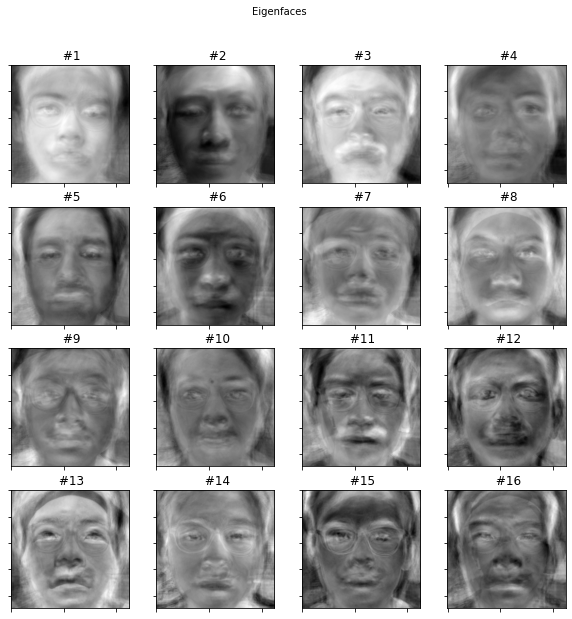

In [16]:
E = []
number = eigenvectors.shape[1]
for i in range(min(number, 16)):
  e = eigenvectors[:, i].reshape(DEFAULT_SIZE)
  E.append(np.asarray(e))

# plot them and save the plot
subplot(title="Eigenfaces", images=E, rows=4, cols=4, colormap=plt.cm.gray, filename="python_pca_eigenfaces.png")

In [17]:
def project(W, X, mu):                        
  return np.matmul(W.T, X - mu)

In [18]:
face_projections = []
for face in faces:
  face_projections.append(project(eigenvectors, face, mean)) # weight vector generation

# Face Recognition Using Eigenfaces

In [19]:
train_accessories_data_dir = "tmp/train_accessories_processed"
[accessory_faces_train, accessory_names_train] = image_to_array(train_accessories_data_dir)

accessory_face_projections_train = []
for face in accessory_faces_train:
  accessory_face_projections_train.append(project(eigenvectors, face, mean))

In [20]:
train_data = []
train_label = []
for i in range(len(face_projections)):
  for j in range(len(accessory_face_projections_train)):
    train_data.append(np.append(face_projections[i], accessory_face_projections_train[j]))
    train_label.append(1 if re.split('(\d+)', accessory_names_train[j])[0] == re.split('(\d+)', names[i])[0] else 0)

## Data Construction

In [21]:
train_df = pd.DataFrame(train_data)
train_df['label'] = train_label
train_df

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,label
0,-6.069617e+08,1.286705e+09,-1.915959e+08,6.477704e+08,-2.806352e+08,2.280086e+07,3.244635e+08,-7.232006e+07,6.869783e+07,-4.783553e+07,...,1.960882e+06,3.790659e+07,-6.411319e+06,-1.735885e+07,2.155765e+07,1.302870e+06,5.026667e+06,-2.164251e+07,-8.290828e+06,1
1,-6.069617e+08,1.286705e+09,-1.915959e+08,6.477704e+08,-2.806352e+08,2.280086e+07,3.244635e+08,-7.232006e+07,6.869783e+07,-4.783553e+07,...,1.085432e+07,4.416620e+07,2.980789e+05,-1.299651e+07,1.580708e+07,2.568957e+06,8.935722e+06,-1.837953e+07,-1.889047e+07,1
2,-6.069617e+08,1.286705e+09,-1.915959e+08,6.477704e+08,-2.806352e+08,2.280086e+07,3.244635e+08,-7.232006e+07,6.869783e+07,-4.783553e+07,...,5.983223e+06,3.129780e+07,-1.135516e+07,-1.264630e+07,1.540888e+07,3.156561e+06,7.251264e+06,-2.808810e+07,-6.529987e+06,1
3,-6.069617e+08,1.286705e+09,-1.915959e+08,6.477704e+08,-2.806352e+08,2.280086e+07,3.244635e+08,-7.232006e+07,6.869783e+07,-4.783553e+07,...,1.097135e+07,3.912845e+07,1.005374e+07,-2.029641e+07,3.497205e+06,-4.838838e+06,1.879303e+07,-1.380645e+07,-2.059014e+07,1
4,-6.069617e+08,1.286705e+09,-1.915959e+08,6.477704e+08,-2.806352e+08,2.280086e+07,3.244635e+08,-7.232006e+07,6.869783e+07,-4.783553e+07,...,6.753082e+05,4.973247e+07,2.703866e+07,-2.314784e+07,1.554075e+07,6.470608e+06,2.563084e+07,-1.482477e+07,1.494224e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7861,-1.109727e+09,-5.092325e+08,5.348030e+08,-2.067093e+08,1.689536e+07,-2.674962e+07,1.402830e+08,3.601070e+07,8.467458e+07,-1.015519e+08,...,-5.755265e+05,1.736736e+07,7.144536e+06,-2.135761e+07,-3.177465e+06,2.256819e+05,1.803182e+07,-1.795145e+07,-5.911799e+06,1
7862,-1.109727e+09,-5.092325e+08,5.348030e+08,-2.067093e+08,1.689536e+07,-2.674962e+07,1.402830e+08,3.601070e+07,8.467458e+07,-1.015519e+08,...,1.481302e+07,4.400357e+07,2.722584e+07,-2.169877e+07,1.914107e+07,1.251864e+07,1.859992e+07,-1.451603e+07,-7.531785e+06,1
7863,-1.109727e+09,-5.092325e+08,5.348030e+08,-2.067093e+08,1.689536e+07,-2.674962e+07,1.402830e+08,3.601070e+07,8.467458e+07,-1.015519e+08,...,1.202428e+07,3.846381e+07,1.891057e+07,-2.710248e+07,2.002032e+07,8.357323e+06,2.405817e+07,-1.789792e+07,-4.273840e+06,1
7864,-1.109727e+09,-5.092325e+08,5.348030e+08,-2.067093e+08,1.689536e+07,-2.674962e+07,1.402830e+08,3.601070e+07,8.467458e+07,-1.015519e+08,...,1.399685e+07,5.230011e+07,2.777011e+07,-2.363242e+07,2.173277e+07,1.633288e+07,1.963628e+07,-1.945811e+07,-1.015401e+07,1


## Class label imbalance

In [22]:
neg, pos = np.bincount(train_df['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 7866
    Positive: 772 (9.81% of total)



## Split and normalize the data

In [23]:
def split_dataset(df, label_column, test_size, val_size, random_state):
  train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
  train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=random_state)

  train_labels = np.array(train_df.pop(label_column))
  bool_train_labels = train_labels != 0
  val_labels = np.array(val_df.pop(label_column))
  test_labels = np.array(test_df.pop(label_column))

  train_features = np.array(train_df)
  val_features = np.array(val_df)
  test_features = np.array(test_df)

  return train_features, train_labels, val_features, val_labels, test_features, test_labels

def preprocess_dataset(train_features, val_features, test_features):
  standard_scaler = preprocessing.StandardScaler()

  train_features = standard_scaler.fit_transform(train_features)
  
  val_features = standard_scaler.transform(val_features)
  test_features = standard_scaler.transform(test_features)

  return train_features, val_features, test_features

In [24]:
label_column = 'label'

X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(train_df, label_column, test_size=0.2, val_size=0.2, random_state=SEED) # positive labels being encoded as 1

X_train_scaled, X_val_scaled, X_test_scaled = preprocess_dataset(X_train, X_val, X_test)

In [25]:
print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (5033,)
Validation labels shape: (1259,)
Test labels shape: (1574,)
Training features shape: (5033, 96)
Validation features shape: (1259, 96)
Test features shape: (1574, 96)


Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.

* **False** negatives and **false** positives are samples that were **incorrectly** classified
* **True** negatives and **true** positives are samples that were **correctly** classified
* **Accuracy** is the percentage of examples correctly classified > $\frac{\text{true samples}}{\text{total samples}}$
* **Precision** is the percentage of **predicted** positives that were correctly classified > $\frac{\text{true positives}}{\text{true positives } + \text{ false positives}}$
* **Recall** is the percentage of **actual** positives that were correctly classified > $\frac{\text{true positives}}{\text{true positives } + \text{ false negatives}}$
* **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
* **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.

## Define the model and metrics

In [26]:
METRICS = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR') # precision-recall curve
]

In [27]:
class EigenfaceHyperModel(kt.HyperModel):
  def __init__(self, output_bias=None):
    self.output_bias = output_bias
  
  def build(self, hp, metrics=METRICS):
    output_bias = None
    if self.output_bias is not None:
      output_bias = keras.initializers.Constant(self.output_bias)
    
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], )))
    model.add(Dense(
        units=hp.Int("layer1_units", min_value=32, max_value=64, step=8),
        activation='relu'
    ))
    model.add(Dense(
        units=hp.Int("layer2_units", min_value=8, max_value=16, step=4),
        activation='relu'
    ))
    model.add(Dense(units=1, activation='sigmoid', bias_initializer=output_bias))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=2e-1, sampling='log')),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
    )
    
    return model

  def evaluate(self, hp, model, *args, **kwargs):
    return model.evaluate(
        *args,
        batch_size=hp.Choice("batch_size", [16, 32]),
        **kwargs
    )

  def fit(self, hp, model, *args, **kwargs):
    return model.fit(
        *args,
        batch_size=hp.Choice("batch_size", [16, 32]),
        **kwargs
    )
  
  def predict(self, hp, model, *args, **kwargs):
    return model.predict(
        *args,
        batch_size=hp.Choice("batch_size", [16, 32]),
        **kwargs
    )

In [28]:
EPOCHS = 100

early_stopping = EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True
)

## Baseline model

In [29]:
baseline_tuner = kt.RandomSearch(
    EigenfaceHyperModel(),
    objective='val_loss',
    max_trials=50,
    seed=SEED,
    overwrite=True
)

In [30]:
baseline_tuner.search(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val)
)

Trial 50 Complete [00h 01m 45s]
val_loss: 0.011745105497539043

Best val_loss So Far: 0.0007009296678006649
Total elapsed time: 00h 42m 07s


In [31]:
#tuner.results_summary()

In [32]:
baseline_best_hps = baseline_tuner.get_best_hyperparameters()[0]
baseline_best_hps.values

{'layer1_units': 64,
 'layer2_units': 8,
 'learning_rate': 0.00827033455176414,
 'batch_size': 32}

In [33]:
# baseline_best_hps_dict = {
#     'layer1_units': 48,
#     'layer2_units': 16,
#     'learning_rate': 0.009243260703470988,
#     'batch_size': 16
# }

# baseline_best_hps = kt.HyperParameters()
# baseline_best_hps.values = baseline_best_hps_dict

In [34]:
baseline_hypermodel = EigenfaceHyperModel()
baseline_best_model = baseline_hypermodel.build(baseline_best_hps)
baseline_best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                6208      
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,737
Trainable params: 6,737
Non-trainable params: 0
_________________________________________________________________


In [35]:
baseline_history = baseline_hypermodel.fit(
    baseline_best_hps,
    baseline_best_model,
    X_train_scaled, y_train,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val)
)

Restoring model weights from the end of the best epoch: 11.
Epoch 31: early stopping


In [36]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    
    plt.legend()

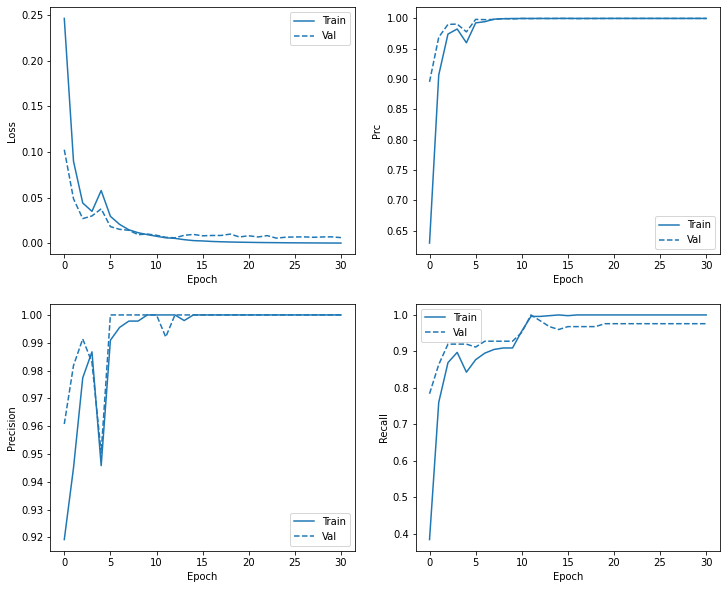

In [37]:
plot_metrics(baseline_history)

In [38]:
baseline_train_predictions = baseline_hypermodel.predict(
    baseline_best_hps,
    baseline_best_model,
    X_train_scaled
)

baseline_test_predictions = baseline_hypermodel.predict(
    baseline_best_hps,
    baseline_best_model,
    X_test_scaled
)

50/50 [==============================] - 0s 1ms/step


In [39]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Mismatched Faces Detected (True Negatives): ', cm[0][0])
  print('Mismatched Faces Incorrectly Detected (False Positives): ', cm[0][1])
  print('Matched Faces Missed (False Negatives): ', cm[1][0])
  print('Matched Faces Detected (True Positives): ', cm[1][1])
  print('Total Mismatched Faces: ', np.sum(cm[0]))

loss :  0.014418760314583778
tp :  144.0
fp :  0.0
tn :  1424.0
fn :  6.0
accuracy :  0.9961880445480347
precision :  1.0
recall :  0.9599999785423279
auc :  0.9965308904647827
prc :  0.9941334128379822

Mismatched Faces Detected (True Negatives):  1424
Mismatched Faces Incorrectly Detected (False Positives):  0
Matched Faces Missed (False Negatives):  6
Matched Faces Detected (True Positives):  144
Total Mismatched Faces:  1424


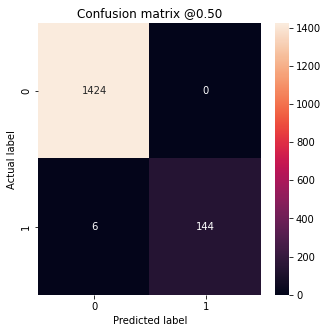

In [40]:
baseline_results = baseline_hypermodel.evaluate(
    baseline_best_hps,
    baseline_best_model,
    X_test_scaled, y_test,
    verbose=0
)

for name, value in zip(baseline_best_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, baseline_test_predictions)

In [41]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5, 2.5])
  plt.ylim([97.5, 100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

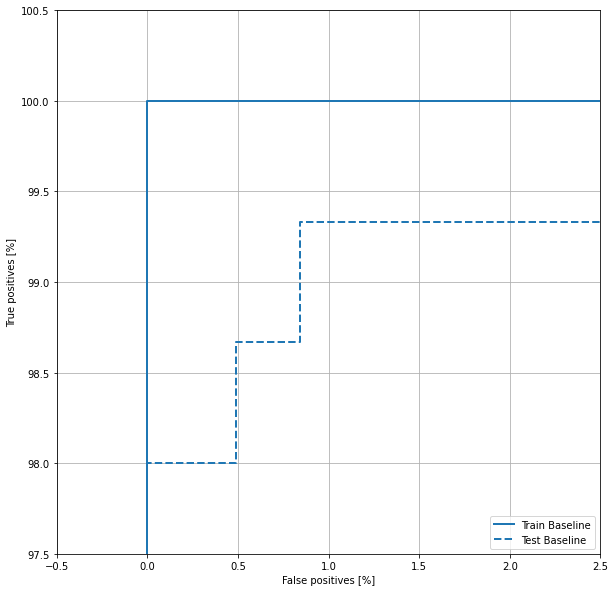

In [42]:
plot_roc("Train Baseline", y_train, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_test_predictions, color=colors[0], linestyle='--')

plt.legend(loc='lower right');

In [86]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim([0.965, 1.005])
    plt.ylim([0.965, 1.005])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

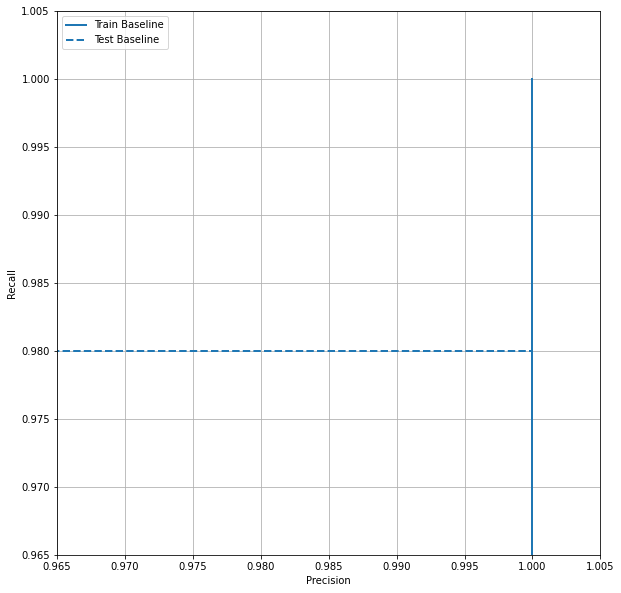

In [87]:
plot_prc("Train Baseline", y_train, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", y_test, baseline_test_predictions, color=colors[0], linestyle='--')

plt.legend(loc='upper left');

## Set the correct initial bias

The dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

The correct bias to set can be derived from:

$$ p_0 = \frac{pos}{pos + neg} = \frac{1}{1+e^{-b_0}} $$
$$ b_0 = -log_e(\frac{1}{p_0} - 1) $$
$$ b_0 = log_e(\frac{pos}{neg}) $$

In [45]:
initial_bias = np.log([pos / neg])
initial_bias

array([-2.21802009])

In [46]:
bias_init_tuner = kt.RandomSearch(
    EigenfaceHyperModel(output_bias=initial_bias),
    objective='val_loss',
    max_trials=50,
    seed=SEED,
    overwrite=True
)

In [47]:
bias_init_tuner.search(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val)
)

Trial 50 Complete [00h 01m 39s]
val_loss: 0.013800960034132004

Best val_loss So Far: 0.00031499823671765625
Total elapsed time: 00h 41m 54s


In [48]:
bias_init_best_hps = bias_init_tuner.get_best_hyperparameters()[0]
bias_init_best_hps.values

{'layer1_units': 48,
 'layer2_units': 12,
 'learning_rate': 0.007323835124151008,
 'batch_size': 32}

In [49]:
# bias_init_best_hps_dict = {
#     'layer1_units': 48,
#     'layer2_units': 12,
#     'learning_rate': 0.007323835124151008,
#     'batch_size': 32
# }

# bias_init_best_hps = kt.HyperParameters()
# bias_init_best_hps.values = bias_init_best_hps_dict

In [50]:
bias_init_hypermodel = EigenfaceHyperModel(output_bias=initial_bias)
bias_init_best_model = bias_init_hypermodel.build(bias_init_best_hps)
bias_init_best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 48)                4656      
                                                                 
 dense_4 (Dense)             (None, 12)                588       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5,257
Trainable params: 5,257
Non-trainable params: 0
_________________________________________________________________


In [51]:
bias_init_history = bias_init_hypermodel.fit(
    bias_init_best_hps,
    bias_init_best_model,
    X_train_scaled, y_train,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val)
)

Restoring model weights from the end of the best epoch: 33.
Epoch 53: early stopping


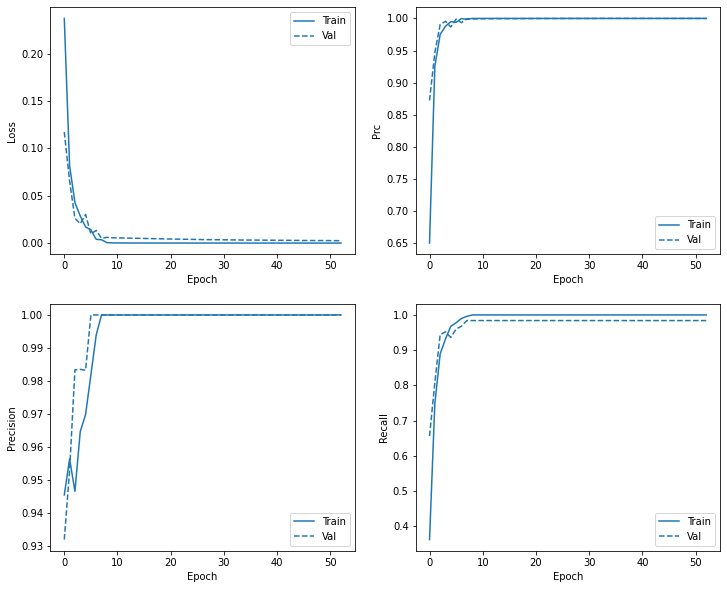

In [52]:
plot_metrics(bias_init_history)

In [53]:
bias_init_train_predictions = bias_init_hypermodel.predict(
    bias_init_best_hps,
    bias_init_best_model,
    X_train_scaled
)

bias_init_test_predictions = bias_init_hypermodel.predict(
    bias_init_best_hps,
    bias_init_best_model,
    X_test_scaled
)

50/50 [==============================] - 0s 1ms/step


loss :  0.019731620326638222
tp :  145.0
fp :  0.0
tn :  1424.0
fn :  5.0
accuracy :  0.9968233704566956
precision :  1.0
recall :  0.9666666388511658
auc :  0.9932655096054077
prc :  0.989760160446167

Mismatched Faces Detected (True Negatives):  1424
Mismatched Faces Incorrectly Detected (False Positives):  0
Matched Faces Missed (False Negatives):  5
Matched Faces Detected (True Positives):  145
Total Mismatched Faces:  1424


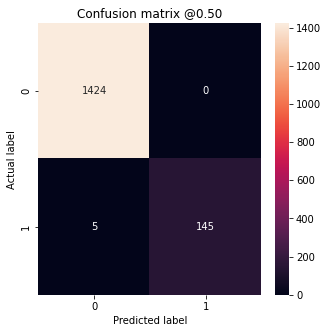

In [54]:
bias_init_results = bias_init_hypermodel.evaluate(
    bias_init_best_hps,
    bias_init_best_model,
    X_test_scaled, y_test,
    verbose=0
)

for name, value in zip(bias_init_best_model.metrics_names, bias_init_results):
  print(name, ': ', value)
print()

plot_cm(y_test, bias_init_test_predictions)

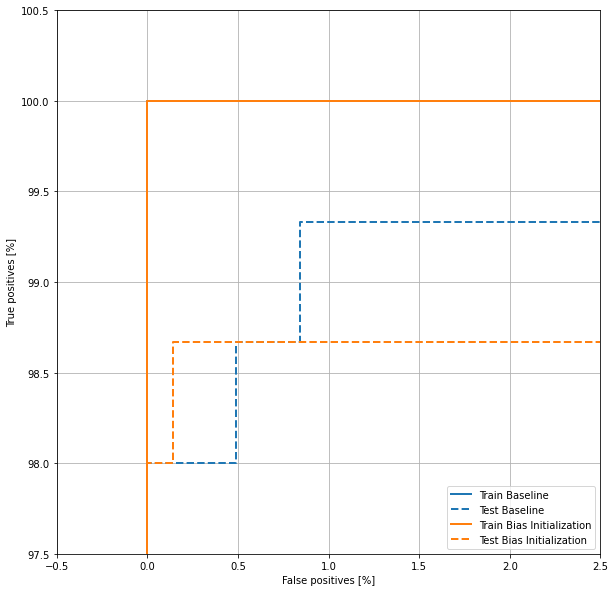

In [55]:
plot_roc("Train Baseline", y_train, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Bias Initialization", y_train, bias_init_train_predictions, color=colors[1])
plot_roc("Test Bias Initialization", y_test, bias_init_test_predictions, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

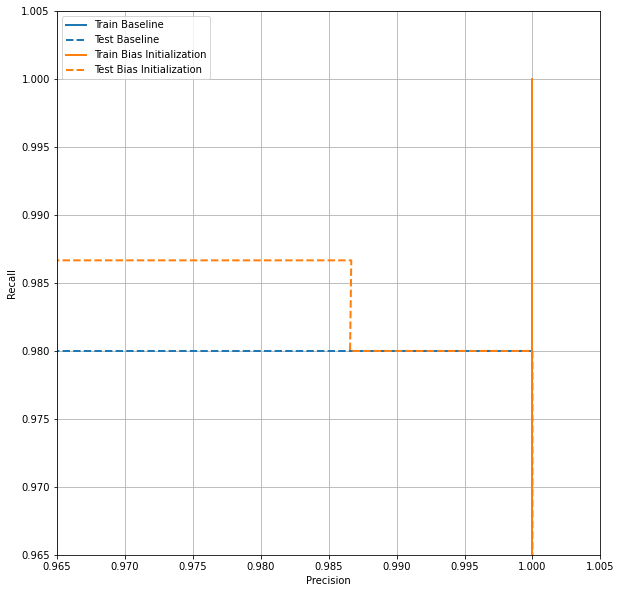

In [88]:
plot_prc("Train Baseline", y_train, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", y_test, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Bias Initialization", y_train, bias_init_train_predictions, color=colors[1])
plot_prc("Test Bias Initialization", y_test, bias_init_test_predictions, color=colors[1], linestyle='--')

plt.legend(loc='upper left');

## Class weights

Passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [57]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.09


In [58]:
weighted_tuner = kt.RandomSearch(
    EigenfaceHyperModel(),
    objective='val_loss',
    max_trials=50,
    seed=SEED,
    overwrite=True
)

In [59]:
weighted_tuner.search(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weight
)

Trial 50 Complete [00h 01m 13s]
val_loss: 0.013915445655584335

Best val_loss So Far: 0.0008720167097635567
Total elapsed time: 00h 48m 52s


In [60]:
weighted_best_hps = weighted_tuner.get_best_hyperparameters()[0]
weighted_best_hps.values

{'layer1_units': 48,
 'layer2_units': 12,
 'learning_rate': 0.0020059585895776293,
 'batch_size': 16}

In [61]:
# weighted_best_hps_dict = {
#     'layer1_units': 56,
#     'layer2_units': 12,
#     'learning_rate': 0.0020763611320450425,
#     'batch_size': 16
# }

# weighted_best_hps = kt.HyperParameters()
# weighted_best_hps.values = weighted_best_hps_dict

In [62]:
weighted_hypermodel = EigenfaceHyperModel()
weighted_best_model = weighted_hypermodel.build(weighted_best_hps)
weighted_best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 48)                4656      
                                                                 
 dense_4 (Dense)             (None, 12)                588       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5,257
Trainable params: 5,257
Non-trainable params: 0
_________________________________________________________________


In [63]:
weighted_history = weighted_hypermodel.fit(
    weighted_best_hps,
    weighted_best_model,
    X_train_scaled, y_train,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weight
)

Restoring model weights from the end of the best epoch: 74.
Epoch 94: early stopping


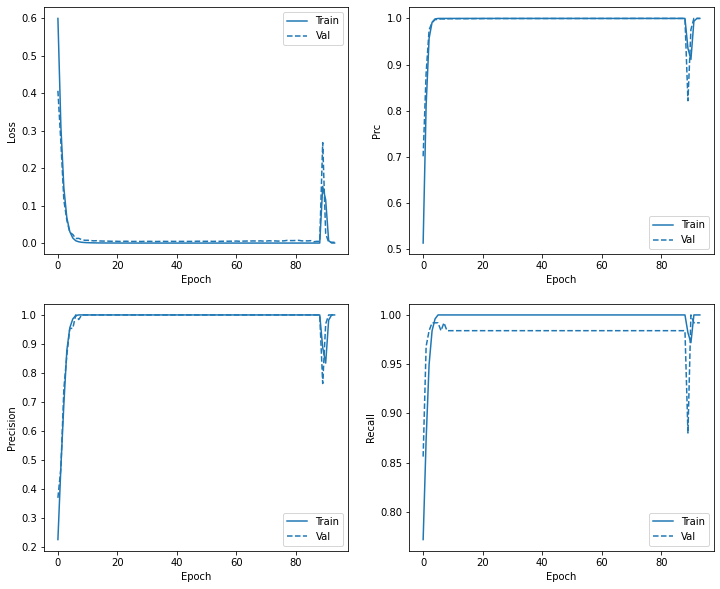

In [64]:
plot_metrics(weighted_history)

In [65]:
weighted_train_predictions = weighted_hypermodel.predict(
    weighted_best_hps,
    weighted_best_model,
    X_train_scaled
)

weighted_test_predictions = weighted_hypermodel.predict(
    weighted_best_hps,
    weighted_best_model,
    X_test_scaled
)

99/99 [==============================] - 0s 1ms/step


loss :  0.00958759430795908
tp :  147.0
fp :  0.0
tn :  1424.0
fn :  3.0
accuracy :  0.9980940222740173
precision :  1.0
recall :  0.9800000190734863
auc :  0.996666669845581
prc :  0.9949801564216614

Mismatched Faces Detected (True Negatives):  1424
Mismatched Faces Incorrectly Detected (False Positives):  0
Matched Faces Missed (False Negatives):  3
Matched Faces Detected (True Positives):  147
Total Mismatched Faces:  1424


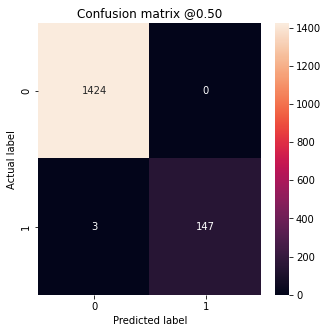

In [66]:
weighted_results = weighted_hypermodel.evaluate(
    weighted_best_hps,
    weighted_best_model,
    X_test_scaled, y_test,
    verbose=0
)

for name, value in zip(weighted_best_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, weighted_test_predictions)

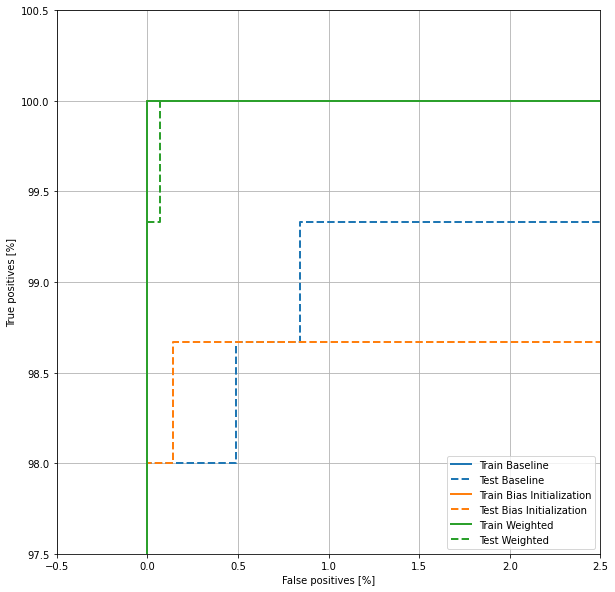

In [67]:
plot_roc("Train Baseline", y_train, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Bias Initialization", y_train, bias_init_train_predictions, color=colors[1])
plot_roc("Test Bias Initialization", y_test, bias_init_test_predictions, color=colors[1], linestyle='--')

plot_roc("Train Weighted", y_train, weighted_train_predictions, color=colors[2])
plot_roc("Test Weighted", y_test, weighted_test_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right');

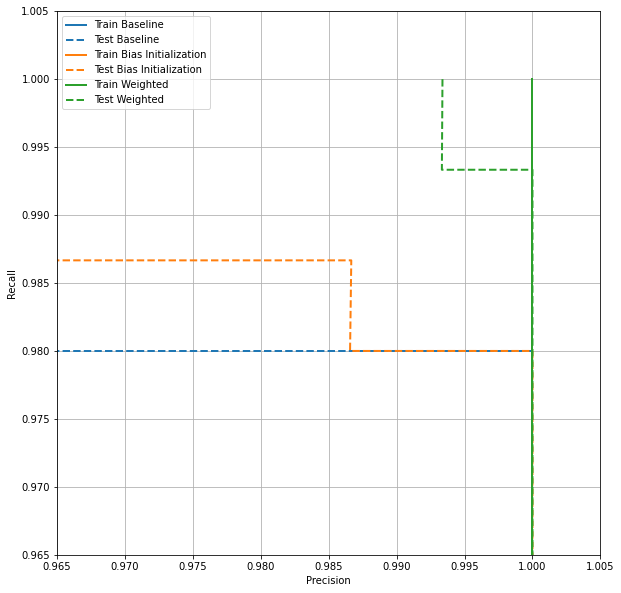

In [89]:
plot_prc("Train Baseline", y_train, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", y_test, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Bias Initialization", y_train, bias_init_train_predictions, color=colors[1])
plot_prc("Test Bias Initialization", y_test, bias_init_test_predictions, color=colors[1], linestyle='--')

plot_prc("Train Weighted", y_train, weighted_train_predictions, color=colors[2])
plot_prc("Test Weighted", y_test, weighted_test_predictions, color=colors[2], linestyle='--')

plt.legend(loc='upper left');

## Oversampling

A related approach would be to resample the dataset by oversampling the minority class.

In [69]:
bool_train_labels = y_train != 0

pos_features = X_train_scaled[bool_train_labels]
neg_features = X_train_scaled[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [70]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(4536, 96)

In [71]:
X_train_resampled = np.concatenate([res_pos_features, neg_features], axis=0)
y_train_resampled = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(y_train_resampled))
np.random.shuffle(order)
X_train_resampled = X_train_resampled[order]
y_train_resampled = y_train_resampled[order]

X_train_resampled.shape

(9072, 96)

In [72]:
# BUFFER_SIZE = 5000

# def make_ds(features, labels):
#   ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
#   ds = ds.shuffle(BUFFER_SIZE).repeat()
#   return ds

# pos_ds = make_ds(pos_features, pos_labels)
# neg_ds = make_ds(neg_features, neg_labels)

# resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
# resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

# resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

# val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

In [73]:
resampled_tuner = kt.RandomSearch(
    EigenfaceHyperModel(),
    objective='val_loss',
    max_trials=50,
    seed=SEED,
    overwrite=True
)

In [74]:
resampled_tuner.search(
    X_train_resampled, y_train_resampled,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val)
)

Trial 50 Complete [00h 01m 14s]
val_loss: 0.011491561308503151

Best val_loss So Far: 0.0006557016749866307
Total elapsed time: 00h 53m 40s


In [75]:
resampled_best_hps = resampled_tuner.get_best_hyperparameters()[0]
resampled_best_hps.values

{'layer1_units': 48,
 'layer2_units': 12,
 'learning_rate': 0.007323835124151008,
 'batch_size': 32}

In [76]:
# resampled_best_hps_dict = {
#     'layer1_units': 48,
#     'layer2_units': 12,
#     'learning_rate': 0.007323835124151008,
#     'batch_size': 32
# }

# resampled_best_hps = kt.HyperParameters()
# resampled_best_hps.values = resampled_best_hps_dict

In [77]:
resampled_hypermodel = EigenfaceHyperModel()
resampled_best_model = resampled_hypermodel.build(resampled_best_hps)
resampled_best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 48)                4656      
                                                                 
 dense_4 (Dense)             (None, 12)                588       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5,257
Trainable params: 5,257
Non-trainable params: 0
_________________________________________________________________


In [78]:
resampled_history = resampled_hypermodel.fit(
    resampled_best_hps,
    resampled_best_model,
    X_train_resampled, y_train_resampled,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val)
)

Restoring model weights from the end of the best epoch: 5.
Epoch 25: early stopping


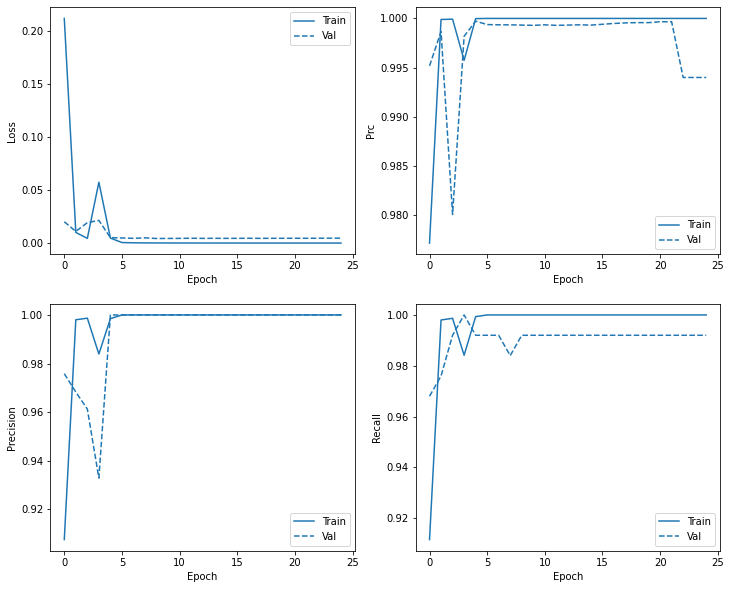

In [79]:
plot_metrics(resampled_history)

In [80]:
resampled_train_predictions = resampled_hypermodel.predict(
    resampled_best_hps,
    resampled_best_model,
    X_train_scaled
)

resampled_test_predictions = resampled_hypermodel.predict(
    resampled_best_hps,
    resampled_best_model,
    X_test_scaled
)

50/50 [==============================] - 0s 1ms/step


loss :  0.0164189450442791
tp :  142.0
fp :  2.0
tn :  1422.0
fn :  8.0
accuracy :  0.9936467409133911
precision :  0.9861111044883728
recall :  0.9466666579246521
auc :  0.9963014721870422
prc :  0.9927650690078735

Mismatched Faces Detected (True Negatives):  1422
Mismatched Faces Incorrectly Detected (False Positives):  2
Matched Faces Missed (False Negatives):  8
Matched Faces Detected (True Positives):  142
Total Mismatched Faces:  1424


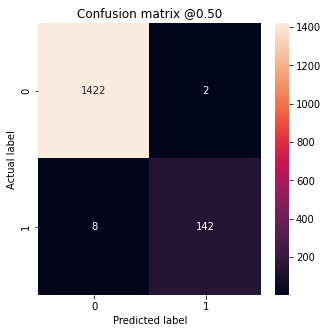

In [81]:
resampled_results = resampled_hypermodel.evaluate(
    resampled_best_hps,
    resampled_best_model,
    X_test_scaled, y_test,
    verbose=0
)

for name, value in zip(resampled_best_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, resampled_test_predictions)

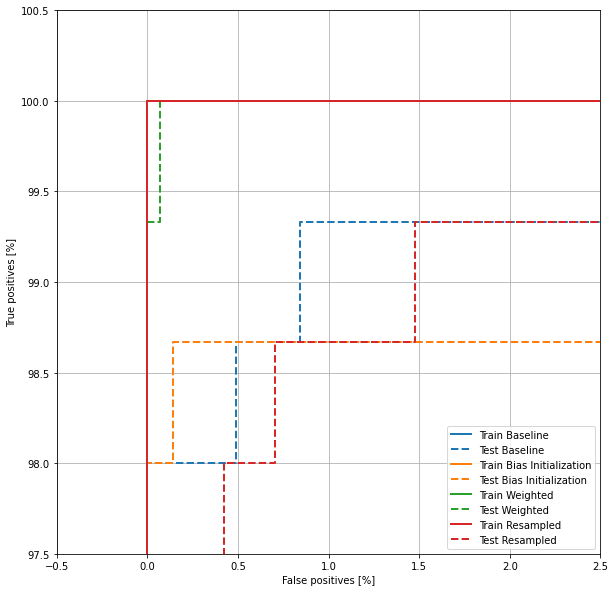

In [82]:
plot_roc("Train Baseline", y_train, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Bias Initialization", y_train, bias_init_train_predictions, color=colors[1])
plot_roc("Test Bias Initialization", y_test, bias_init_test_predictions, color=colors[1], linestyle='--')

plot_roc("Train Weighted", y_train, weighted_train_predictions, color=colors[2])
plot_roc("Test Weighted", y_test, weighted_test_predictions, color=colors[2], linestyle='--')

plot_roc("Train Resampled", y_train, resampled_train_predictions, color=colors[3])
plot_roc("Test Resampled", y_test, resampled_test_predictions, color=colors[3], linestyle='--')

plt.legend(loc='lower right');

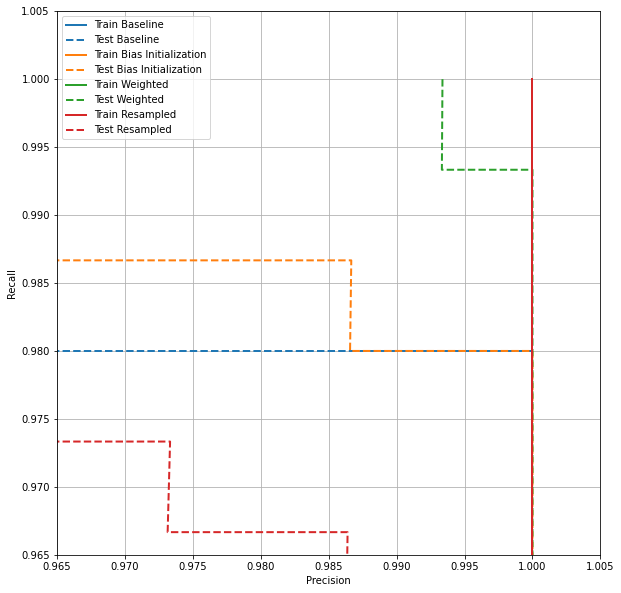

In [90]:
plot_prc("Train Baseline", y_train, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", y_test, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Bias Initialization", y_train, bias_init_train_predictions, color=colors[1])
plot_prc("Test Bias Initialization", y_test, bias_init_test_predictions, color=colors[1], linestyle='--')

plot_prc("Train Weighted", y_train, weighted_train_predictions, color=colors[2])
plot_prc("Test Weighted", y_test, weighted_test_predictions, color=colors[2], linestyle='--')

plot_prc("Train Resampled", y_train, resampled_train_predictions, color=colors[3])
plot_prc("Test Resampled", y_test, resampled_test_predictions, color=colors[3], linestyle='--')

plt.legend(loc='upper left');

# Prediction of unknown faces

In [ ]:
number_of_faces = {}

for name in names:
  name = re.split('(\d+)', name)[0]

  try:
    number_of_faces[name] += 1
  except:
    number_of_faces[name] = 1

In [ ]:
number_of_faces

{'varshini_dad': 7,
 'wei_de': 16,
 'varshini_mom': 7,
 'damien': 15,
 'varshini_bro': 7,
 'tommy': 7,
 'yc': 7,
 'frank': 7,
 'victor': 12,
 'jh': 15,
 'ricardo': 7,
 'yz': 7}

In [ ]:
test_image_path = "damien.jpg"

test_image = Image.open(test_image_path)
test_image = ImageOps.exif_transpose(test_image)
test_image = test_image.convert('L')  # greyscale
test_image = test_image.resize(DEFAULT_SIZE)

test_face = np.asarray(test_image, dtype=np.uint8).reshape(-1, 1)

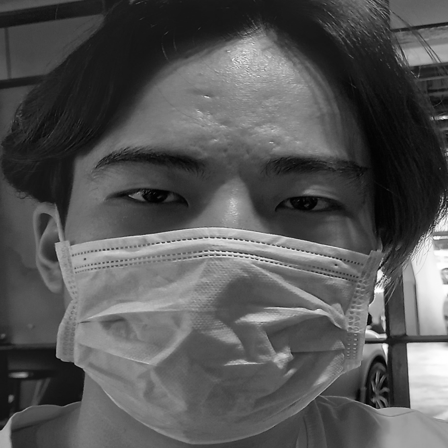

In [ ]:
test_image

In [ ]:
test_face_projection = project(eigenvectors, test_face, mean)

In [ ]:
test_data = []
test_label = []
for i in range(len(face_projections)):
  test_data.append(np.append(face_projections[i], test_face_projection))
  # test_label.append(1 if re.split('(\d+)', test_face_projection)[0] == re.split('(\d+)', names[i])[0] else 0)

In [ ]:
test_df = pd.DataFrame(test_data)
# test_df['label'] = test_label
test_df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-1.508125e+08,2.568773e+08,-1.103874e+09,1.165053e+08,-2.014068e+08,4.798530e+08,-2.057075e+08,2.662724e+08,-8.747542e+07,1.291406e+08,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07
1,2.001002e+08,-5.498148e+08,-8.513981e+08,-4.077728e+08,-2.296829e+08,-2.221647e+08,5.186873e+07,1.346070e+08,8.344998e+07,6.311382e+07,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07
2,2.156320e+08,-5.950467e+08,-7.788591e+08,-5.560633e+08,-3.547556e+08,-1.447661e+08,1.311594e+08,1.031410e+08,2.091017e+07,7.120767e+07,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07
3,2.001002e+08,-5.498148e+08,-8.513981e+08,-4.077728e+08,-2.296829e+08,-2.221647e+08,5.186873e+07,1.346070e+08,8.344998e+07,6.311382e+07,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07
4,-1.092255e+08,-5.585184e+08,-8.808296e+08,-4.223388e+08,-3.387228e+08,-1.489222e+08,5.231386e+07,1.955043e+08,5.339106e+07,1.113549e+07,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,-5.384183e+07,2.058799e+08,5.289282e+08,7.553380e+07,4.761582e+07,-1.799493e+08,8.857126e+07,3.032341e+08,-1.588823e+07,-1.126518e+08,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07
110,-1.913647e+08,2.174940e+08,4.677114e+08,-5.926127e+07,-3.245891e+07,-1.419377e+08,3.116123e+07,3.171289e+08,-9.668369e+06,-1.049608e+08,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07
111,-2.670626e+08,2.055516e+08,3.921968e+08,-1.835437e+08,-6.533508e+07,-1.100961e+08,2.682514e+07,3.054812e+08,-1.295266e+07,-7.674617e+07,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07
112,3.107897e+07,3.280600e+08,3.618430e+08,6.009473e+07,8.050846e+07,-2.956400e+08,1.546303e+08,2.288809e+08,6.952332e+06,-8.005867e+07,...,1.806933e+06,9.598326e+06,-4.276610e+06,1.084219e+07,5.911839e+06,-8.445973e+06,-416459.603037,-3.262046e+06,8.511864e+06,1.554482e+07


In [ ]:
test_features = np.array(test_df)

standard_scaler = preprocessing.StandardScaler()

train_features = standard_scaler.fit_transform(X_train)
test_features = standard_scaler.transform(test_features)

In [ ]:
test_predictions = resampled_hypermodel.predict(
    resampled_best_hps,
    resampled_best_model,
    test_features
)

4/4 [==============================] - 0s 3ms/step


In [ ]:
predicted_indices = np.where(np.squeeze(test_predictions) > 0.5)[0].tolist()

In [ ]:
face_predictions = {}

for index in predicted_indices:
  name = re.split('(\d+)', names[index])[0]
  try:
    face_predictions[name] += 1
  except:
    face_predictions[name] = 1

face_predictions = dict(sorted(face_predictions.items(), key=lambda item: item[1]))

for face in face_predictions.keys():
  face_predictions[face] /= number_of_faces[name]

In [ ]:
face_predictions

{'damien': 1.0}